# Importing neceassary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from itertools import cycle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.regularizers import l1, l2
from scikeras.wrappers import KerasClassifier

/var/folders/j9/j6p747vj52j4bx0m5hm_3w140000gn/T/ipykernel_9735/1586126209.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Creating the dataframe

In [13]:
def read_csv_create_train_test(test_split, features):
    """
    test_split (input): The percentage of data that will be used to test
    features (input): Can be 'all', 'anova' or 'extratrees'
    """
    # Specify the pattern for your csv files
    csv_files = glob.glob('trial/*.csv')

    # List comprehension to load all csv files into DataFrames
    dataframes = [pd.read_csv(file) for file in csv_files]

    # Concatenate all DataFrames into one
    combined_dataframe = pd.concat(dataframes, ignore_index=True)

    # # Remove stop command - trial
    # combined_dataframe = combined_dataframe[combined_dataframe['Movement'] != 4]

    # # Shuffle the dataset to ensure a good mix of data points -- traintestsplit already does this
    # combined_dataframe = shuffle(combined_dataframe, random_state=42)

    # some columns are totally unproductive so let's remove them
    combined_dataframe.drop(['Sample Count'],axis=1,inplace=True)

    if features == 'all':
        # All features
        X = combined_dataframe.drop(['Movement'],axis=1)
    elif features == 'anova':
        # Features based on ANOVA F-Test
        features = ['Mean', 'Skewness', 'Kurtosis', 'Relative Theta Power', 'Relative Alpha Power', 'Relative Beta Power',
                    'Relative Gamma Power', 'Relative Mu Power', 'Entropy', 'Complexity', 'Bispectrum Relative Theta Power',
                    'Bispectrum Relative Alpha Power', 'Bispectrum Relative Beta Power', 'Bispectrum Relative Gamma Power', 'Third Moment']
        X = combined_dataframe.drop(['Movement'],axis=1)
    elif features == 'extratrees':
        # Feature based on ExtraTreesClassifier
        features = ['Relative Theta Power', 'Bispectrum Relative Gamma Power', 'Bispectrum Relative Delta Power', 'Entropy', 'Relative Beta Power', 'Bispectrum Relative Mu Power', 'Bispectrum Relative Theta Power', 'Activity', 'Skewness', 'Zero Crossing Rate']
        X = combined_dataframe[features]
    y = combined_dataframe.Movement

    # Convert labels to one-hot encoding
    y = to_categorical(y)  # Ensure this matches the classes correctly

    # Splitting the dataset into the Training set and Test set. Stratify should keep all classes of movement balanced
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_split, random_state = 42, stratify=y)

    # Feature Scaling because we don't want one independent variable dominating the other and it makes computations easy
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)

    return combined_dataframe, X_train, X_test, y_train, y_test

# ANOVA F-Test

Mean: ANOVA F-test p-value = 0.5960639433242083
Variance: ANOVA F-test p-value = 0.1104602513365603
Skewness: ANOVA F-test p-value = 0.7906232831932855
Kurtosis: ANOVA F-test p-value = 0.8958159083686746
Relative Delta Power: ANOVA F-test p-value = 0.2897772330259673
Relative Theta Power: ANOVA F-test p-value = 0.7924585584218508
Relative Alpha Power: ANOVA F-test p-value = 0.4265253042714674
Relative Beta Power: ANOVA F-test p-value = 0.3534245696535241
Relative Gamma Power: ANOVA F-test p-value = 0.42791741286303264
Relative Mu Power: ANOVA F-test p-value = 0.5076316881617337
Entropy: ANOVA F-test p-value = 0.8939325970724916
Zero Crossing Rate: ANOVA F-test p-value = 0.0753589022208563
Activity: ANOVA F-test p-value = 0.1104602513365603
Mobility: ANOVA F-test p-value = 0.2897772330259673
Complexity: ANOVA F-test p-value = 0.5960639433242083
Bispectrum Relative Delta Power: ANOVA F-test p-value = 0.2897772330259673
Bispectrum Relative Theta Power: ANOVA F-test p-value = 0.89581590836

<BarContainer object of 22 artists>

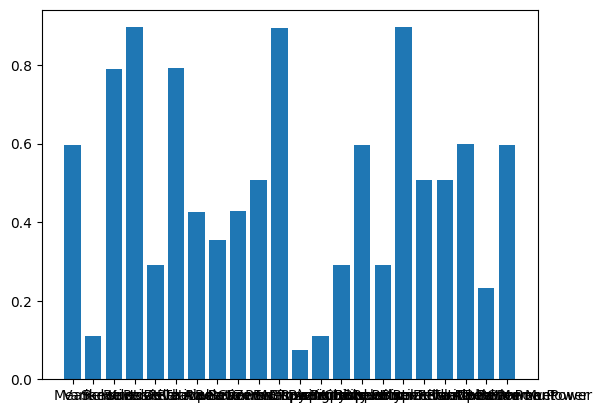

In [66]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

df, X_train, X_test, y_train, y_test = read_csv_create_train_test(test_split=0.05, features='all')

# Separate features and target
X = df.drop(['Movement'], axis=1)
y = df.Movement

# Store column names
feature_names = X.columns

cutoff = 0.3

# # # Scale the features
# # scaler = StandardScaler()
# # X_scaled = scaler.fit_transform(X)

# Apply ANOVA F-test
anova_selector = SelectKBest(f_classif, k='all')  # Set k='all' to get scores for all features
X_kbest = anova_selector.fit_transform(X, y)

# Get the p-values for each feature
p_values = anova_selector.pvalues_

# Print the p-values
for i, col in enumerate(X.columns):
    print(f"{col}: ANOVA F-test p-value = {p_values[i]}")

# List to store features with p-value > 0.2
features_with_high_p_value = [col for i, col in enumerate(X.columns) if p_values[i] > cutoff]

# Print the list of features with p-value > 0.2
print(f"Features with p-value > {cutoff}:", features_with_high_p_value)

plt.bar(feature_names, p_values, width=0.8, bottom=None, align='center')

# ['Mean', 'Skewness', 'Kurtosis', 'Relative Theta Power', 'Relative Alpha Power', 'Relative Beta Power', 'Relative Gamma Power', 'Relative Mu Power', 'Entropy', 'Complexity', 'Bispectrum Relative Theta Power', 'Bispectrum Relative Alpha Power', 'Bispectrum Relative Beta Power', 'Bispectrum Relative Gamma Power', 'Third Moment']

# Extra Trees

[0.04317154 0.04597233 0.0530963  0.04335525 0.04534212 0.04662091
 0.0440775  0.04803416 0.03801681 0.03993342 0.04741867 0.05475481
 0.05190181 0.0457773  0.04128036 0.04704648 0.05173551 0.03601276
 0.03905338 0.04699268 0.05018567 0.0402202 ]


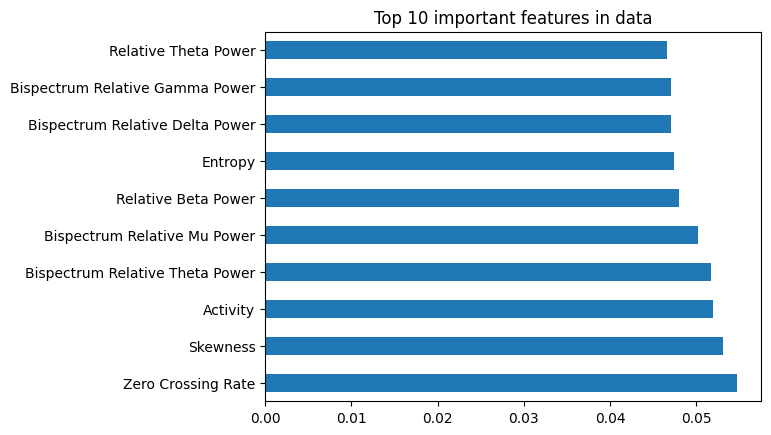

In [88]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt

df, X_train, X_test, y_train, y_test = read_csv_create_train_test(test_split=0.05, features='all')

# Separate features and target
X = df.drop(['Movement'], axis=1)
y = df.Movement

model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) ## use inbuilt class feature_importances of tree based classifiers
## plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title("Top 10 important features in data")
plt.show()

# ['Relative Theta Power', 'Bispectrum Relative Gamma Power', 'Bispectrum Relative Delta Power', 'Entropy', 'Relative Beta Power', 'Bispectrum Relative Mu Power', 'Bispectrum Relative Theta Power', 'Activity', 'Skewness', 'Zero Crossing Rate']

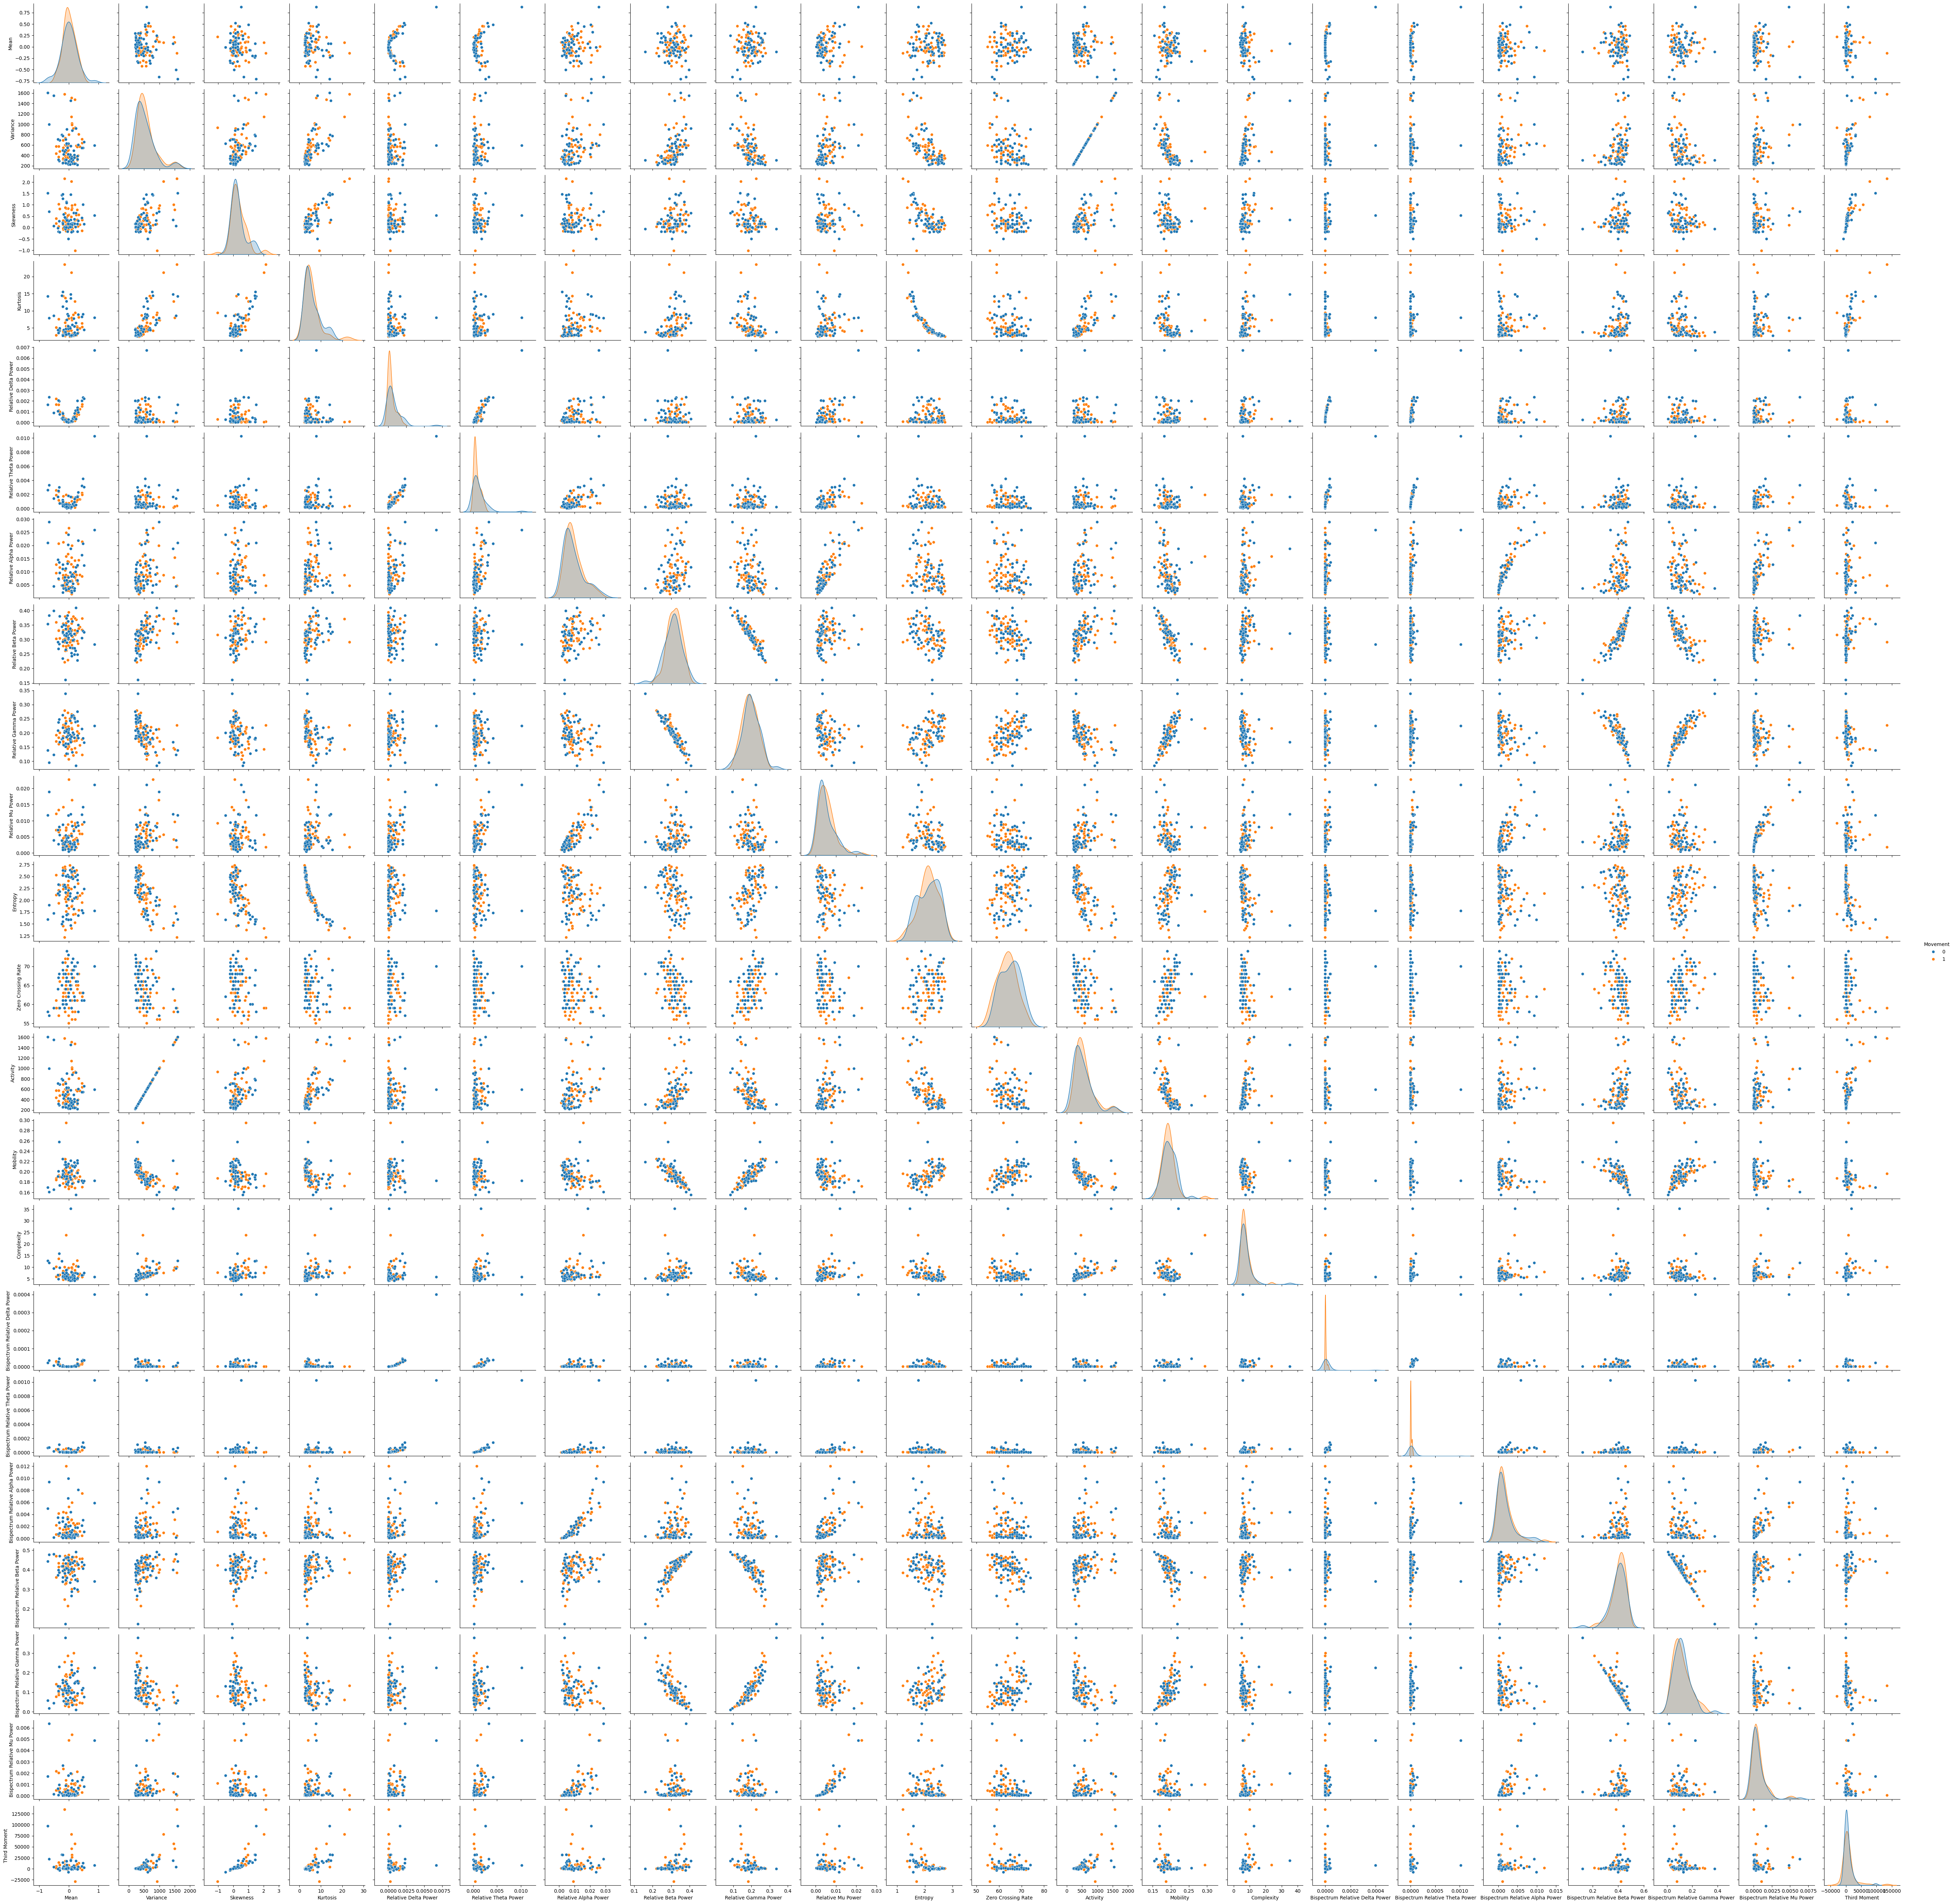

In [15]:
# sns.pairplot(df, hue="Movement")

# Heatmap

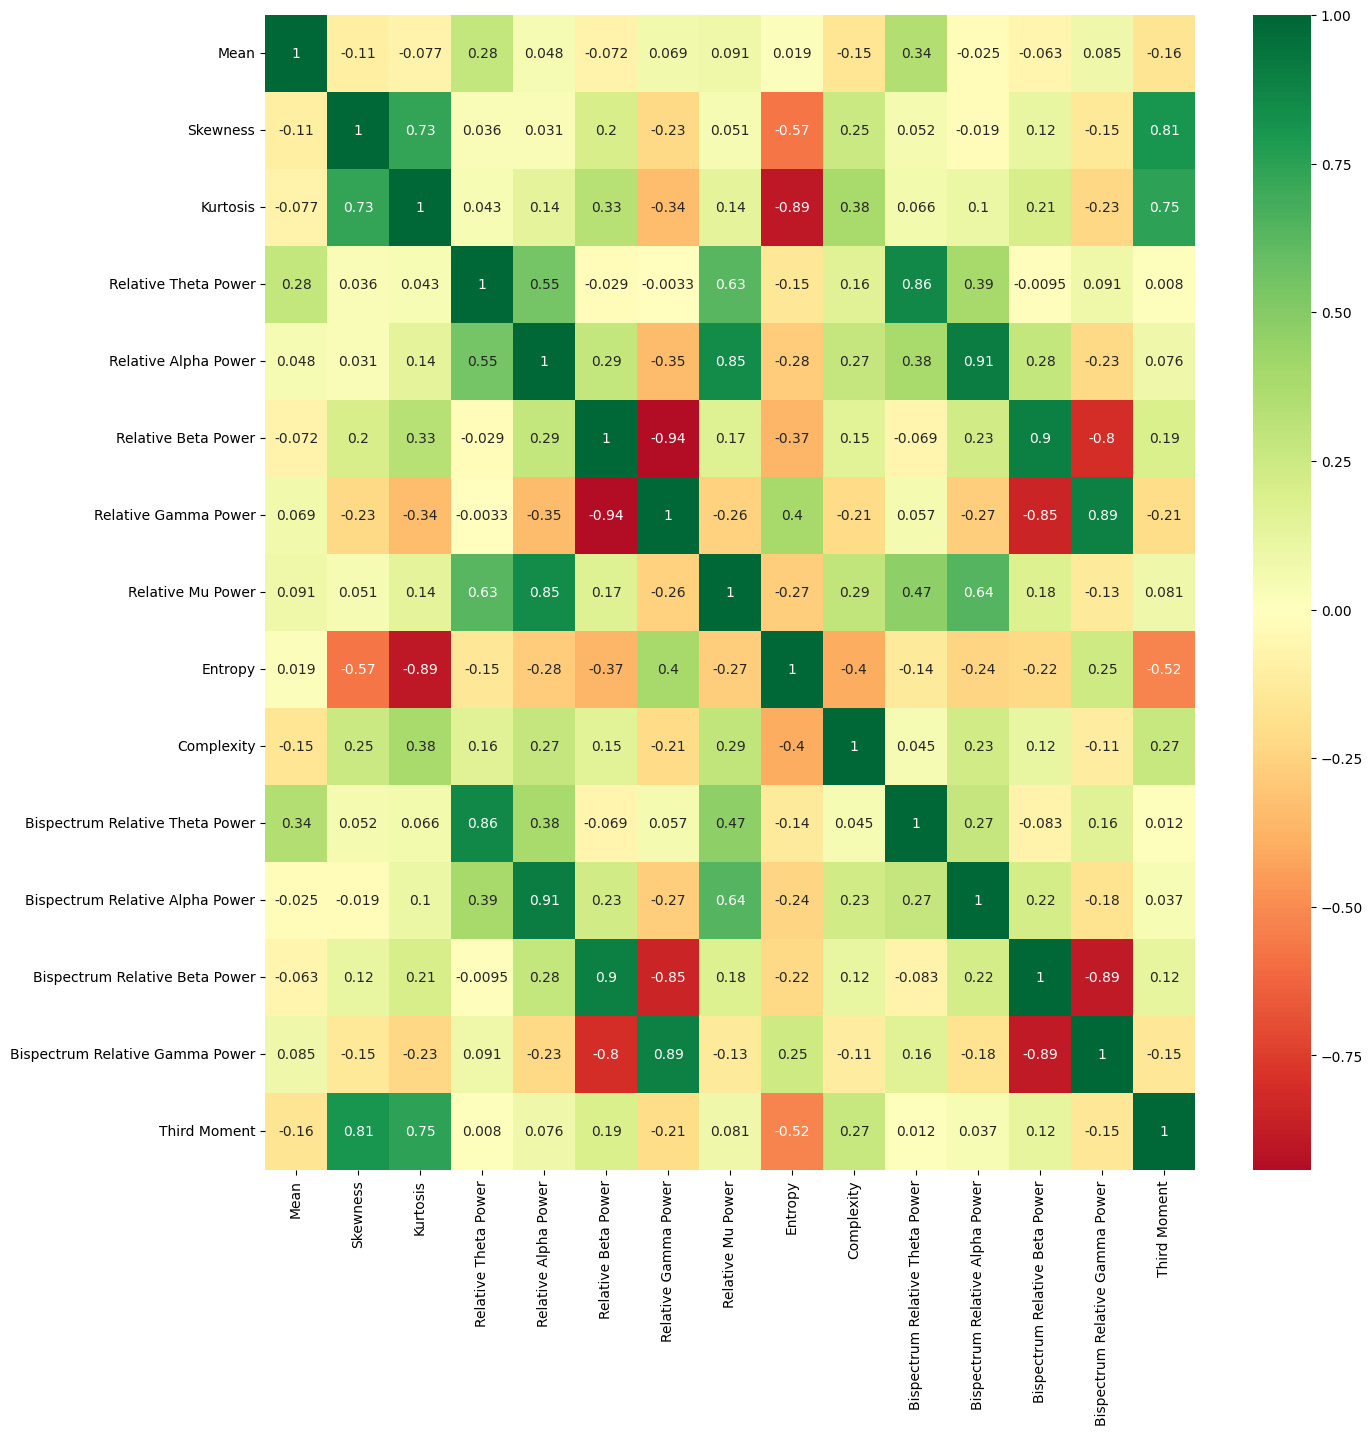

In [69]:
# features = ['Mean', 'Skewness', 'Kurtosis', 'Relative Theta Power', 'Relative Alpha Power', 'Relative Beta Power',
#             'Relative Gamma Power', 'Relative Mu Power', 'Entropy', 'Complexity', 'Bispectrum Relative Theta Power',
#             'Bispectrum Relative Alpha Power', 'Bispectrum Relative Beta Power', 'Bispectrum Relative Gamma Power', 'Third Moment']
# df1 = df[features]

# plt.figure(figsize=(15,15))
# p=sns.heatmap(df1.corr(), annot=True,cmap='RdYlGn',center=0)

# Some statistics about the dataframe

In [18]:
# sns.countplot(y=combined_dataframe.Movement ,data=combined_dataframe)
# plt.xlabel("Count of each Target class")
# plt.ylabel("Target classes")
# plt.show()

# Feature distribution for entire dataframe

In [19]:
# combined_dataframe.hist(figsize=(15,12),bins = 15)
# plt.title("Features Distribution")
# plt.show()

# Feature distribution for forward movement

In [20]:
# forward_dataframe = combined_dataframe.loc[combined_dataframe['Movement'] == 1]
# forward_dataframe

In [21]:
# forward_dataframe.hist(figsize=(15,12),bins = 15)
# plt.title("Features Distribution for forward movement")
# plt.show()

# Feature distribution for backward movement

In [22]:
# backward_dataframe = combined_dataframe.loc[combined_dataframe['Movement'] == 2]
# backward_dataframe

In [23]:
# backward_dataframe.hist(figsize=(15,12),bins = 15)
# plt.title("Features Distribution for backward movement")
# plt.show()

# Feature distribution for stop movement

In [24]:
# left_dataframe = combined_dataframe.loc[combined_dataframe['Movement'] == 3]
# left_dataframe

In [25]:
# left_dataframe.hist(figsize=(15,12),bins = 15)
# plt.title("Features Distribution for left movement")
# plt.show()

In [26]:
# right_dataframe = combined_dataframe.loc[combined_dataframe['Movement'] == 4]
# right_dataframe

In [27]:
# right_dataframe.hist(figsize=(15,12),bins = 15)
# plt.title("Features Distribution for right movement")
# plt.show()

In [28]:
# stop_dataframe = combined_dataframe.loc[combined_dataframe['Movement'] == 5]
# stop_dataframe

In [29]:
# stop_dataframe.hist(figsize=(15,12),bins = 15)
# plt.title("Features Distribution for stop movement")
# plt.show()

# Create dataframe

In [14]:
df, X_train, X_test, y_train, y_test = read_csv_create_train_test(test_split=0.05, features='anova')
df

Mean  Variance  Skewness  Kurtosis  Relative Delta Power  \
0   -0.031676   397.720  0.222947   3.66197              0.000010   
1   -0.192777   688.341  0.214774  14.28050              0.000299   
2    0.252038   581.324  0.548699   5.43108              0.000560   
3   -0.124504   596.708  0.621884   6.51049              0.000141   
4   -0.023624   425.698  0.831517   8.64309              0.000008   
..        ...       ...       ...       ...                   ...   
106  0.318869   600.800  0.292392   8.86798              0.000940   
107 -0.113624   304.588 -0.068357   3.76332              0.000239   
108  0.294011   384.257 -0.184553   3.39975              0.001164   
109 -0.089210   314.903  0.000639   3.06526              0.000140   
110 -0.075413   626.939  1.081700  10.61770              0.000058   

     Relative Theta Power  Relative Alpha Power  Relative Beta Power  \
0                0.000152              0.004086             0.228550   
1                0.000624              0.008663             0.354038   
2                0.001556              0.006767             0.367756   
3                0.000377              0.010530             0.378933   
4                0.000149              0.006486             0.315970   
..                    ...                   ...                  ...   
106              0.002287              0.021803             0.349508   
107              0.000215              0.003643             0.160390   
108              0.001644              0.012448             0.247548   
109              0.000603              0.003049             0.311971   
110              0.000258              0.006749             0.320809   

     Relative Gamma Power  Relative Mu Power  ...  Mobility  Complexity  \
0                0.270728           0.003298  ...  0.209046     6.49115   
1                0.159167           0.003640  ...  0.177156     8.30434   
2                0.130681           0.001637  ...  0.188415    10.44660   
3                0.119664           0.002686  ...  0.170286     8.05190   
4                0.198186           0.004691  ...  0.192985     5.37464   
..                    ...                ...  ...       ...         ...   
106              0.181559           0.008468  ...  0.180525    10.22710   
107              0.338081           0.003406  ...  0.218549     5.06630   
108              0.240686           0.009407  ...  0.216404     7.17604   
109              0.205028           0.002198  ...  0.208074     8.71653   
110              0.184825           0.002063  ...  0.186296     6.04099   

     Bispectrum Relative Delta Power  Bispectrum Relative Theta Power  \
0                       8.680690e-10                     4.044320e-07   
1                       8.571780e-07                     5.104270e-06   
2                       2.193960e-06                     2.345640e-05   
3                       1.282590e-07                     1.235080e-06   
4                       4.908830e-10                     5.125360e-07   
..                               ...                              ...   
106                     7.411330e-06                     6.256890e-05   
107                     4.431550e-07                     4.792800e-07   
108                     1.462270e-05                     3.948020e-05   
109                     1.628530e-07                     8.067640e-06   
110                     2.937660e-08                     8.203640e-07   

     Bispectrum Relative Alpha Power  Bispectrum Relative Beta Power  \
0                           0.000161                        0.214457   
1                           0.001426                        0.419338   
2                           0.000947                        0.464404   
3                           0.002030                        0.469824   
4                           0.000603                        0.398551   
..                               ...                             ...   
106                         0.008

# Training the ANN model

In [15]:
def build_model():
    # Initialising the ANN
    classifier = Sequential()

    # Adding the input layer ##and the first hidden layer
    classifier.add(Dense(units=256, activation='relu', input_dim=X_train.shape[1], kernel_regularizer=l1(0.01)))
    classifier.add(BatchNormalization())
    classifier.add(Dropout(0.5))

    # Adding the second hidden layer
    classifier.add(Dense(units=128, activation='relu', kernel_regularizer=l2(0.01)))
    classifier.add(BatchNormalization())
    classifier.add(Dropout(0.5))

    # Adding the output layer
    classifier.add(Dense(units=2, activation='softmax'))  # Change here for multi-class

    # Compiling the ANN
    adam = Adam(learning_rate=0.001)
    sgd = SGD(learning_rate=0.001, momentum=0.9)
    rmsprop = RMSprop(learning_rate=0.001, rho=0.9)
    classifier.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

    return classifier

In [22]:
model = build_model()

# Create an EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Training the ANN on the Training set
model.fit(X_train, y_train, validation_split=0.05, batch_size=16, epochs=500, callbacks=[early_stopping])

# Predicting the Test set results
y_pred = model.predict(X_test)

# Evaluate the model
_, accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy*100:.2f}%')


Epoch 1/500


2024-02-15 09:15:11.588037: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


7/7 [==============================] - 2s 214ms/step - loss: 7.0771 - accuracy: 0.4747 - val_loss: 6.3431 - val_accuracy: 0.5000
Epoch 2/500
7/7 [==============================] - 0s 31ms/step - loss: 6.8009 - accuracy: 0.5253 - val_loss: 6.1753 - val_accuracy: 0.3333
Epoch 3/500
7/7 [==============================] - 0s 26ms/step - loss: 6.5551 - accuracy: 0.5758 - val_loss: 6.0224 - val_accuracy: 0.1667
Epoch 4/500
7/7 [==============================] - 0s 24ms/step - loss: 6.2415 - accuracy: 0.5152 - val_loss: 5.8668 - val_accuracy: 0.1667
Epoch 5/500
7/7 [==============================] - 0s 24ms/step - loss: 5.9068 - accuracy: 0.5657 - val_loss: 5.6984 - val_accuracy: 0.1667
Epoch 6/500
7/7 [==============================] - 0s 24ms/step - loss: 5.6537 - accuracy: 0.6263 - val_loss: 5.5897 - val_accuracy: 0.3333
Epoch 7/500
7/7 [==============================] - 0s 25ms/step - loss: 5.6007 - accuracy: 0.5455 - val_loss: 5.4717 - val_accuracy: 0.5000
Epoch 8/500
7/7 [==============

# Creating a confusion matrix to visualize how accurate the model is

[[2 1]
 [0 3]]


Text(0.5, 23.52222222222222, 'Predicted label')

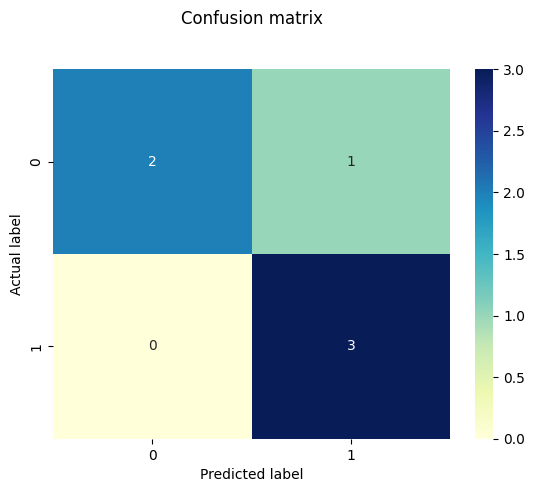

In [23]:
# Convert probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert one-hot encoded y_test to class labels
y_test_classes = np.argmax(y_test, axis=1)

# Making the Confusion Matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
print(cm)

# Plot the confusion matrix
p = sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# Classification report

In [24]:
#import classification_report
print(classification_report(y_test_classes,y_pred_classes))

              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.75      1.00      0.86         3

    accuracy                           0.83         6
   macro avg       0.88      0.83      0.83         6
weighted avg       0.88      0.83      0.83         6



1/1 [==============================] - 0s 22ms/step


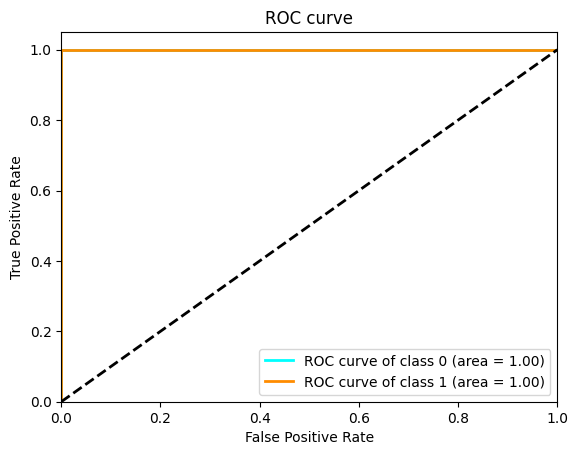

In [25]:
# Assuming your model is 'classifier' and already trained
y_pred_proba = model.predict(X_test)

# Compute ROC curve and ROC area for each class
n_classes = y_test.shape[1]  # Assuming y_test is one-hot encoded
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting the ROC Curve
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()
